###    Pipeline to illustrate GWAS ina tetraploid species
    It uses gen format instead of vcf. gen format contains
       chr pos alleles ....
    space / tab separated


In [1]:
import numpy as np
import gzip
import sys
import time
import os
import matplotlib.pyplot as plt

# specific seqbreed modules
from SeqBreed import genome as gg
from SeqBreed.selection import selection as sel

In [2]:
# current dir
cdir = os.getcwd()

# working directory
wdir = cdir

# input file dir
ddir = cdir

# working files, seqfile contains snp positions from vcf
# this file is generated by gg.GFounder below
seqfile = 'seq.pos'

# list of chips that can be analyzed, include sequence as output from gg.GFounder()
chipfiles = [seqfile]
# contains qtn positions
qtnfile = ddir + '/potato.qtn.pos'
# gene dropping pedigree
pedfile = ddir + '/potato.ped'
# snp file in gen format
genfile = ddir + '/potato.gen.gz'

# goto working directory
os.chdir(wdir)

In [3]:
# STEP 1:
# uploads genotypes and generates snp positions (snpFile)
# NOTE that ploidy level must be specified if gen format
gbase = gg.GFounder(vcfFile=genfile, snpFile=seqfile, ploidy=4)

# STEP 2: generates Genome object with chr names, recombination map, etc
gfeatures = gg.Genome(snpFile=seqfile, ploidy=gbase.ploidy)

# prints some basic info
gfeatures.print()

# STEP 3: read QTN file
qtn = gg.QTNs(h2=[0.5, 0.7], genome=gfeatures, qtnFile=qtnfile)
qtn.get_var(gfeatures,gbase)

# STEP 4: generate base population
pop = gg.Population(gfeatures, pedFile=None, generation=None, qtns=qtn, gfounders=gbase)
qtn.print(gfeatures)

ploidy: 4
N base: 150
N snps: 396
GENOME FEATURES (ploidy = 4)
Chr  Type   bplength    Nsnps length_m length_f
1  Autos  87463611 47 [0.87463611, 0.87463611]
2  Autos  47326485 34 [0.47326485, 0.47326485]
3  Autos  61870684 41 [0.61870684, 0.61870684]
4  Autos  72022392 42 [0.72022392, 0.72022392]
5  Autos  51998374 28 [0.51998374, 0.51998374]
6  Autos  58259275 41 [0.58259275, 0.58259275]
7  Autos  54961836 32 [0.54961836, 0.54961836]
8  Autos  55254403 24 [0.55254403, 0.55254403]
9  Autos  61466245 36 [0.61466245, 0.61466245]
10  Autos  59236087 21 [0.59236087, 0.59236087]
11  Autos  45059903 30 [0.45059903, 0.45059903]
12  Autos  60754928 20 [0.60754928, 0.60754928]
All        715674223  396 [7.15674223 7.15674223]

#h2 by trait 0.5 0.7
#se by trait 13.150557353946983 2.244442178828752
#CHR POS FRQ ADD_0 DOM_0 VA_0 VD_0 ADD_1 DOM_1 VA_1 VD_1
1 11774418 0.815 11.7184051065355 0.0 41.409153050536545 0.0 0.0 0.0 0.0 0.0
1 44702400 0.367 1.39262477399802 0.0 0.9007453024021878 0.0 -0.62

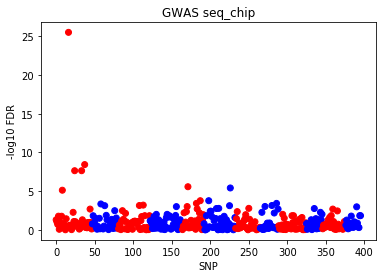

In [4]:
# STEP 5: Simulate a F2 between the 10 most extreme lowest and highest lines for second phenotype
#--> Sort phenotypes and sel parents
itrait = 1
nsel = 10
y = np.array(list(pop.inds[i].y[itrait] for i in range(pop.n))) # phenotypes
yindex = np.argsort(y)
ilow = yindex[:nsel]
ihigh = np.random.permutation(yindex[-nsel:]) # random mating between extremes

#--> F1 between lowest and highest inds
n0 = pop.n
for i in range(nsel):
    parents = [pop.inds[ilow[i]], pop.inds[ihigh[i]] ]
    pop.addInd(parents, genome=gfeatures, gfounders=gbase, qtns=qtn, id=None, sex=None, t=1)

#--> F2 by selfcrossing
noff = 20
n1 = pop.n
for i in range(nsel):
    iid = n0+i # index of parent
    parents = [pop.inds[iid], pop.inds[iid]]
    for j in range(noff):
        pop.addInd(parents, genome=gfeatures, gfounders=gbase, qtns=qtn, id=None, sex=None, t=2)

# STEP 5: GWAS
# generate chip objects
chipseq = gg.Chip(chipFile=seqfile, genome=gfeatures, name='seq_chip')

# get genotypes
X = gg.do_X(pop.inds, gfeatures, gbase, chip=chipseq)

# GWAS for second trait
gwas = sel.Gwas(X, chipseq)
gwas.fit(pop.inds, trait=1)
gwas.plot(fdr=True)    # FDR

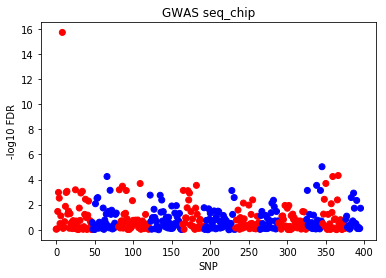

#CHR POS COEFF SE PVALUE FDR
1 559640 0.2152732725695477 1.0485261372885242 0.8374463436869061 0.9036205779291956
1 1838864 0.23993873028763968 0.7989944052836813 0.7641219588070158 0.854780496292594
1 4258451 2.469293802998086 0.9007391363374266 0.006424660071626092 0.03485158066251962
1 5431075 -4.18474468302786 1.0296110434042485 5.923203636144238e-05 0.001066176654505963
1 6071917 -3.0667588720555465 0.8278041667859263 0.0002450778597422227 0.0030328385143100055
1 6143327 -2.295563087230109 1.6667076563495047 0.16927878158656717 0.3221169496342922
1 6295542 2.5372626548155486 1.0983802201635573 0.021456136818664984 0.07867250166843828
1 6587872 -1.2907217835847309 1.2828086717438938 0.3150140572956028 0.49898226675623486
1 11774418 8.469003065939265 0.8970617668230669 4.872334033043168e-19 1.9294442770850945e-16
1 13546944 0.6959140871792124 1.5697768782541361 0.6578017978270209 0.7799087183817374
1 29676849 -1.0380235410613101 1.3257682880311263 0.43416821932689786 0.6140379101908

In [5]:
# GWAS for first trait
gwas = sel.Gwas(X, chipseq)
gwas.fit(pop.inds, trait=0)
gwas.plot(fdr=True)    # FDR
gwas.print(gfeatures)  # prints gwas results

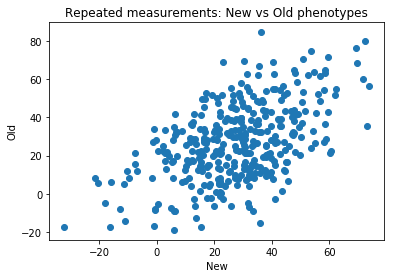

In [6]:
# Appendix: How to simulate repeated measurements
itrait = 0
current_y = np.array(list(ind.y[itrait] for ind in pop.inds))
new_y = np.array([])
for ind in pop.inds:
    y = ind.g_add[itrait] + ind.g_dom[itrait] + np.random.normal(0, qtn.se[itrait])
    new_y = np.append(new_y, y)

# plot new_y vs current_y
plt.scatter(new_y, current_y)
plt.title('Repeated measurements: New vs Old phenotypes')
plt.xlabel('New')
plt.ylabel('Old')
plt.show()
plt.close()

In [ ]:
# Easy, isn't it?